# **GlyNet**
- a nerual network that accurately predicts interactions (relative binding strengths) between mammalian glycans and 352 glycan-binding proteins, many at multiple concentrations. 

- for each glycan input, the model will produce 1257 outputs, each representing the relative interaction strength between the input glycan and a particular protein sample.

- see https://www.biorxiv.org/content/10.1101/2021.05.28.446094 

# Load Libraries

In [1]:
# directory 
data_dir = '/content'  # likely '/contents' on Google Colab, 'Data' otherwise
results_dir = 'Results' # output directory

# load libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import math
import random
import time
import os.path
import sys
import collections
import re

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rcParams

from sklearn.metrics import r2_score
from PIL import Image
from skimage import io, img_as_float

# Initialize Learning Environment and Functions

In [2]:
torch.manual_seed(0) # Seed the PRNG from http://pytorch.org/docs/master/notes/randomness.html

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using:', device)

using: cpu


# **Train A New Neural Network**

*   This section will train a new model. 
*   A pre-trained model is also available (and is used later in the notebook), skip to the "Load Trained GlyNet" section to see use the trained model.

## GlyNet - Architecture

In [3]:
class GlyNet(nn.Module):
    """Set up the neural network.
    in_dim: Number of input neurons.
    out_dim: Number of output neurons.
    n_hidden_layers: Number of hidden layers. Default: 1
    n_neurons_per_hidden_layer: Number of neurons in each hidden layer. Default: 100"""
    def __init__(self, in_dim, out_dim, n_hidden_layers = 1,
                 n_neurons_per_hidden_layer = 100, **extra):
        super(GlyNet, self).__init__()
        self.settings = locals()        # record the local variables of interest
        del self.settings['__class__'], self.settings['self'], self.settings['extra']
        self.layers = nn.ModuleList()   # initialize the neural net structures
        current_dim = in_dim
        for i in range(n_hidden_layers):
            self.layers.append(nn.Linear(current_dim, n_neurons_per_hidden_layer))
            current_dim = n_neurons_per_hidden_layer
        self.layers.append(nn.Linear(current_dim, out_dim))
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.nn.functional.relu(layer(x))
        return self.layers[-1](x)       # no ReLU on last layer - causes failures
    def get_parameters(self):           # report the recorded parameters
        return self.settings

## Data Preprocessing

In [4]:
def get_data(n_datasets = None, dataset_offset = 0, permute_seed = None, **extras):
    """Load lists of glycans, their fingerprints and corresponding log RFU data.
    Optionally, the columns of RFUs can be permuted and a subset sselected.
    permute_seed: PRNG-seed used to reorder the RFU columns. None = identity permutation. Default: None
    n_datasets: Number of the RFU output columns to select. None = all. Default: None
    dataset_offset: Position of the first permuted RFU column to return. Default = 0"""

    parameters = locals()   # log the function arguments
    del parameters['extras']

    # load the feature vectors (fingerprints) for the glycans
    fingpr_data = pd.read_csv(os.path.join(data_dir, 'Fingerprints.tsv'),
                              sep = '\t', float_precision = 'round_trip')
    glycans = fingpr_data['Glycan'].tolist()
    fingprs = fingpr_data.drop('Glycan', axis = 1).values.tolist()
    
    # load pre-processed log RFU values
    rfu_data = pd.read_csv(os.path.join(data_dir, 'Avg. RFU.tsv'),
                           sep = '\t', float_precision = 'round_trip')
    
    # do a reproducible permutation of the RFU data columns (protein samples)
    # default (None) skips this - i.e. uses the identity permutation
    perm = list(range(rfu_data.shape[1]))
    if permute_seed != None:
        prng = np.random.default_rng(seed = permute_seed)
        prng.shuffle(perm)

    # select RFU column samples (proteins) with n_datasets from dataset_offset
    if n_datasets == None:  # if n_datasets is unset, make it all of them
        n_datasets = rfu_data.shape[1] - dataset_offset
        parameters['n_datasets'] = n_datasets  # return the actual value used
    rfu_data = rfu_data.iloc[:, perm[dataset_offset:dataset_offset + n_datasets]]

    # create a list of instances, each is a tuple of
    # (label (glycan string), NN input features, target NN output RFUs)
    data = list(zip(glycans, fingprs, rfu_data.values.tolist()))

    # return the instance list, record of the parameters, and data dimensions
    samples = rfu_data.columns.tolist()
    in_dim = len(fingprs[0])
    out_dim = len(rfu_data.columns)
    return data, samples, in_dim, out_dim, parameters


def k_fold_prng(data, parameters, n_folds = 10, fold_seed = None, **extra):
    """k-fold cross validation with random sampling.
    data: List of instances to be divided into test and validation lists.
    n_folds: Number of folds to partition into.  Default = 10.
    fold_seed: Seed PNRG used to assign folds.  Disabled if None. Default: None
    prarameters: Additional value, modified to return parameters used."""

    parameters.update(locals())  # record the arguments
    del parameters['data'], parameters['parameters'], parameters['extra']

    # use a unique PRNG just for this function
    prng = np.random.default_rng(seed = fold_seed)

    # assign each fingerprint to one of the subsets - randomized by shuffle
    fingerprint = dict.fromkeys([tuple(x[1]) for x in data])
    key_list = list(fingerprint.keys())
    prng.shuffle(key_list)
    for i, key in enumerate(key_list):
        fingerprint[key] = i % n_folds
    
    # data is assigned a fold based on its fingerprint's random label
    # ensures that validation data does not contain glycans used for learning
    # final shuffle ensures a random ordering of the data in each fold
    #prng.shuffle(data)   # newer numpy warns when shuffle applied to data
    permutation = list(range(len(data)))
    prng.shuffle(permutation)
    data = [data[i] for i in permutation]

    # iterate over the folds yielding lists of hold-out and keep-in data
    for i in range(n_folds):
        training_data = [x  for x in data  if fingerprint[tuple(x[1])] != i]
        testing_data  = [x  for x in data  if fingerprint[tuple(x[1])] == i]
        if n_folds == 1:     # if only 1 fold is requested training_data is empty
            training_data = testing_data   # this causes error so provide all
        yield i, testing_data, training_data


def prepare_data(data, parameters, batch_size = 64, mode = 'train'):
    """Prepare inputs and desired outputs for training or testing.
    data: List of instances.
    batch_size: Training batch size. Default: 64
    mode: Set to 'test' or 'train'. Default: 'train'."""

    fingpr_tensors, rfu_tensors = [], []
    for glycan_name, fingpr, rfu in data:
        fingpr_tensors.append(torch.tensor(fingpr).float().to(device))
        rfu_tensors.append(torch.tensor(rfu).float().to(device))
    if mode == 'train':
        parameters['batch_size'] = batch_size  # only added if used
        trainset = list(zip(fingpr_tensors, rfu_tensors))
        return torch.utils.data.DataLoader(trainset, batch_size = batch_size)
    elif mode == 'test':
        fingpr_stack = torch.stack(fingpr_tensors).float().to(device)
        rfu_stack = torch.stack(rfu_tensors).float().to(device)
        return fingpr_stack, rfu_stack

## GlyNet - Training

In [25]:
def early_stop(losses, patience):
    """Return True if the loss hasn't improved for a number of epochs.
    patience: Number of epochs without improvement."""
    if min(losses) < min(losses[-patience:]):
        return True

### def customLoss(output, target):
###    # loss fucntion - returns MSE but no loss at negative target values
###    delta = (output - target) * (target >= 0)
###    return torch.mean(delta**2)

def train(weight_decay = 1e-4, patience = 10, plot = False, **kwargs):
    """Train GlyNet using k-fold cross-validation on the CFG data.
    weight_decay: Weight decay of the ADAM optimizer. Default: 1e-4.
    patience: Number of epochs without improvement for early stopping. Default: 10.
    plot: Produce a plot of the losses vs. epoch. Default: False
    Additonal arguments are passed to subfunctions."""

    # track the parameters used (especially default ones)
    parameters = locals()
    del parameters['plot'], parameters['kwargs']

    # load and initialize the data, neural network, etc.
    data, samples, in_dim, out_dim, data_parameters = get_data(**kwargs)
    parameters.update(data_parameters)
    
    net = GlyNet(in_dim, out_dim, **kwargs).to(device)
    parameters.update(net.get_parameters())
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), weight_decay = weight_decay)

    # look over the k-folds    
    glycans, actual, predicted, fold_num, monitor_data  = [], [], [], [], []
    for i, held_out, kept_in in k_fold_prng(data, parameters, **kwargs):
        start_time = time.time()
        train_losses, test_losses = [], []
        trainloader = prepare_data(kept_in, parameters, mode = 'train')
        print('Fold', i + 1, 'Held Out')
        for layers in net.children():
            for layer in layers:
                layer.reset_parameters()
        # now run the training cycles
        for epoch in range(1000):
            # run one step of learning
            batch_loss = 0.0
            for inputs, values in trainloader:
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, values)
                loss.backward()
                optimizer.step()
                batch_size, _ = values.size()
                batch_loss += loss.item() * batch_size
            train_loss = batch_loss / len(kept_in)
            train_losses.append(train_loss)
            
            # test the quality of this step
            test_inputs, test_values = prepare_data(held_out, parameters, mode='test')
            with torch.no_grad():
                test_outputs = net(test_inputs)
                test_loss = criterion(test_outputs, test_values)
            test_losses.append(test_loss.item())
            if early_stop(test_losses, patience):
                break

        # post training - note the time and performance on the hold out material
        elapsed_time = time.time() - start_time
        glycans += [name for name, fingprint, rfu in held_out]
        actual  += [rfu  for name, fingprint, rfu in held_out]
        predicted += test_outputs.tolist()
        fold_num += [i for x in held_out]
        monitor_data.append([elapsed_time, epoch, train_loss, test_loss.item()])
        torch.save(net.state_dict(), 'trained_model-{}.pt'.format(i))
        print('Train Loss:', round(train_loss, 4))
        print('Test Loss:', round(test_loss.item(), 4))
        if plot:
            plot_performance(train_losses, test_losses)
            
    print('GlyNet Cross-Validation Complete')

    act_data  = pd.DataFrame(actual,    index = glycans, columns = samples)
    pred_data = pd.DataFrame(predicted, index = glycans, columns = samples)
    fold_data = pd.DataFrame(fold_num,  index = glycans)
    monitor_data = pd.DataFrame(monitor_data, columns = ['Training Time',
                                        'Epochs', 'Training Loss', 'Test Loss'])
    monitor_data = monitor_data.reset_index().rename(columns = {'index':'Fold'})
    
    return act_data, pred_data, fold_data, monitor_data, parameters

def plot_performance(train_losses, test_losses):
    """Utility function to produce plots of training and test loss by epoch."""
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

def run_learning_and_save(results_dir, plot = False, **parameters_in):
    """A driver function to call train() and save the results to a file.
    results_dir: directory to save the output file in
    other parameters are passed to the train() function
    If the output file already exists training is skipped. Useful for resuming interrupted runs."""
    # build a filename from the non-default parameters
    description =  ' '.join(['{}={}'.format(k, v)   for k, v in parameters_in.items()])
    file_name = os.path.join(results_dir, 'GlyNet {}.npz'.format(description))
    print('Results Filename: {}'.format(file_name))

    if not os.path.exists(file_name):
        act_data, pred_data, fold_data, monitor_data, parameters_out = train(
                                                   plot = plot, **parameters_in)
        # report on the parameter lists
        print('Parameter Lists (In) :', parameters_in)
        print('Parameter Lists (Out):', parameters_out)
        unknowns = [k  for k in parameters_in.keys()  if k not in parameters_out]
        if len(unknowns) > 0:
            sys.stderr.write('Warning: Unused parameter(s) {}\n'.format(unknowns))

        #sample_stats_table = get_per_sample_stats(act_data, pred_data)
        #glycan_stats_table = get_per_sample_stats(act_data.T, pred_data.T)

        # save outputs to one file - can be reloaded with np.load()
        os.makedirs(results_dir, exist_ok = True)
        with open(file_name, 'wb') as data_file:
            np.savez_compressed(data_file,
                # use format that does not require pickle() to load
                parameters = np.array([(k, str(v))
                                            for k, v in parameters_out.items()]),
                index = list(pred_data.index),
                columns = list(pred_data.columns),
                act_data = act_data.values,
                pred_data = pred_data.values,
                fold_data = fold_data.values,
                monitor_columns = list(monitor_data.columns),
                monitor_data = monitor_data.values,
                #statistics_columns = list(sample_stats_table.columns),
                #sample_statistics = sample_stats_table.values,
                #glycan_statistics = glycan_stats_table.values
                )
        return act_data, pred_data, fold_data, monitor_data, parameters_out

# function to load the file written by the above
def load_learned_run(filename):
    with np.load(filename, allow_pickle = False) as the_file:
        parameters   = the_file['parameters']
        idx          = the_file['index']           # list of glycans
        cols         = the_file['columns']         # list of dataset IDs
        act_data     = pd.DataFrame(the_file['act_data'],  index = idx, columns = cols)
        pred_data    = pd.DataFrame(the_file['pred_data'], index = idx, columns = cols)
        fold_data    = pd.DataFrame(the_file['fold_data'], index = idx)
        monitor_cols = the_file['monitor_columns']
        monitor_data = pd.DataFrame(the_file['monitor_data'], columns = monitor_cols)
        #stats_cols   = the_file['statistics_columns']
        #sample_stats = pd.DataFrame(the_file['sample_statistics'],
        #				index = cols, columns = stats_cols)
        #glycan_stats = pd.DataFrame(the_file['glycan_statistics'],
        #				index = idx, columns = stats_cols)
    return (act_data, pred_data, fold_data, monitor_data, parameters)


def get_per_sample_stats(act_data, pred_data, threshold = None):
    """Makes a dataframe with statistics comparing a set of predictions with the
    ground truth values.
    act_data: data frame with the actual (ground truth) values
    pred_data: data frame with the predicted values
    threshold: Only consider glycans with a actual number above this value.  Use None for no filtering. Default=None."""
    mse_list, r2_list, count_list = [], [], []
    for sample in act_data.columns:
        compare_df = pd.DataFrame({'act' : act_data[sample].values,
                                   'pred' : pred_data[sample].values})
        
        # only consider glycans when the actual value is above the threshold
        if threshold != None:  # filter out values when actual is not above threshold
            compare_df = compare_df[compare_df['act'] >= thres]

        # record the MSE and R-squared statistics 
        if (len(compare_df['act']) > 0):
            mse_list.append(np.mean((compare_df['act'] - compare_df['pred'])**2))      
            r2_list.append(r2_score(compare_df['act'], compare_df['pred']))
        else:
            mse_list.append(np.nan)      
            r2_list.append(np.nan)
        count_list.append(len(compare_df['act'])) # record the number of glycans
   
    # organize the results into data frame and return in
    results = pd.DataFrame({'Sample': act_data.columns, 'MSE': mse_list,
                            'R-Squared': r2_list, 'n': count_list})
    results = results.set_index('Sample')
    results['MSE+(1-R2)'] = results['MSE'] - results['R-Squared'] + 1
    return results

Results Filename: Results/GlyNet .npz
Fold 1 Held Out
Train Loss: 0.0817
Test Loss: 0.119


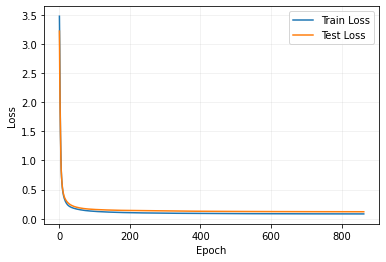

Fold 2 Held Out
Train Loss: 0.0809
Test Loss: 0.1255


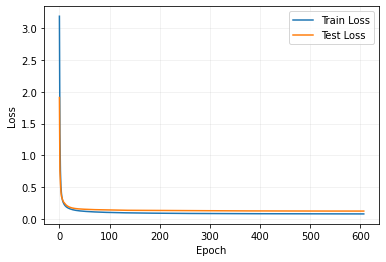

Fold 3 Held Out
Train Loss: 0.0786
Test Loss: 0.1207


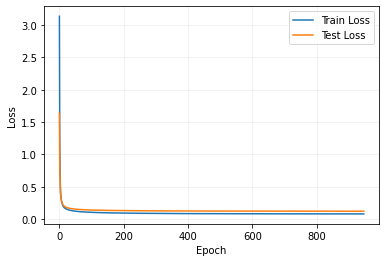

Fold 4 Held Out
Train Loss: 0.0794
Test Loss: 0.1295


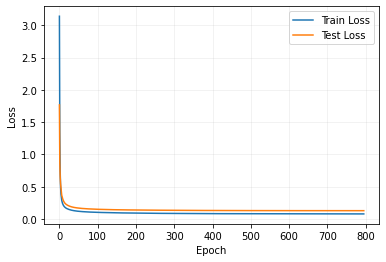

Fold 5 Held Out
Train Loss: 0.0787
Test Loss: 0.1157


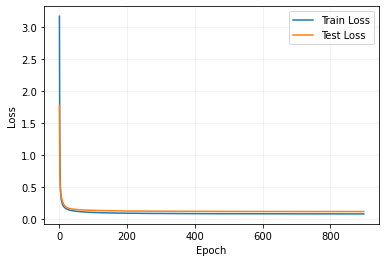

Fold 6 Held Out
Train Loss: 0.079
Test Loss: 0.1287


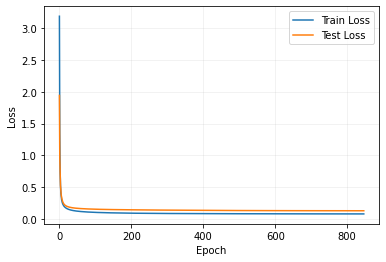

Fold 7 Held Out
Train Loss: 0.0792
Test Loss: 0.1163


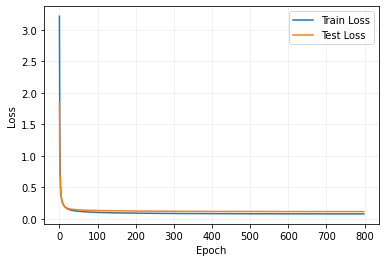

Fold 8 Held Out
Train Loss: 0.081
Test Loss: 0.1109


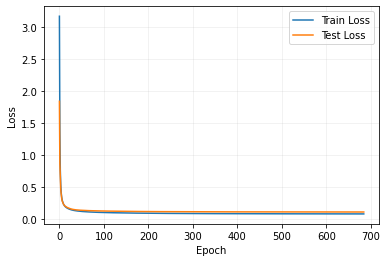

Fold 9 Held Out
Train Loss: 0.0803
Test Loss: 0.1154


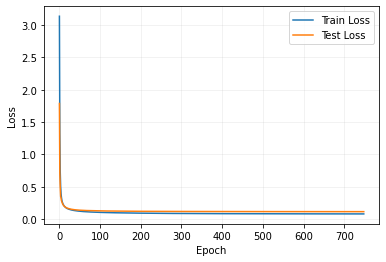

Fold 10 Held Out
Train Loss: 0.0795
Test Loss: 0.122


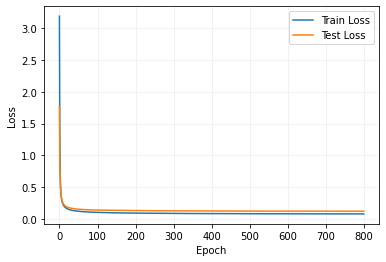

GlyNet Cross-Validation Complete
Parameter Lists (In) : {}
Parameter Lists (Out): {'weight_decay': 0.0001, 'patience': 10, 'n_datasets': 1257, 'dataset_offset': 0, 'permute_seed': None, 'in_dim': 272, 'out_dim': 1257, 'n_hidden_layers': 1, 'n_neurons_per_hidden_layer': 100, 'n_folds': 10, 'fold_seed': None, 'batch_size': 64}


In [16]:
(act_data, pred_data, fold_data, monitor_data,
     parameters_out) = run_learning_and_save(results_dir = results_dir, plot = True)


In [ ]:
# the code here takes a while to run

# sweep across hidden_nodes and n_hidden_layers
run_learning_and_save(results_dir, n_hidden_layers = 0, fold_seed = 0)
size_list = [int(float('{:0.2g}'.format(np.floor(25 * 2 ** (x/2)))))
             for x in range(12)] #  a real hack - but the numbers are nice
node_list = [(l, n)  for l in range(4)  for n in size_list]
for fold_seed, (n_hidden_layers, n_neurons_per_hidden_layer) in enumerate(node_list):
    run_learning_and_save(results_dir, n_hidden_layers = n_hidden_layers, 
                          n_neurons_per_hidden_layer = n_neurons_per_hidden_layer,
                          fold_seed = fold_seed)

# sweep across weight_decay and n_hidden_layers
decay_list = [(l, float('{}e{}'.format(m, e)))  for l in [1, 2, 3]
                                                for e in [-6, -5, -4, -3, -2, -1]
                                                for m in [1, 2, 5]]
for fold_seed, (n_hidden_layers, weight_decay) in enumerate(decay_list):
    run_learning_and_save(results_dir, n_hidden_layers = n_hidden_layers,
                          weight_decay = weight_decay, fold_seed = fold_seed)

# explore subsets of the data at different granularities
factors = [1, 2, 3, 4, 6, 8, 10, 15, 20, 30, 40, 60, 80, 100, 150,
           200, 300, 400, 600, 1200] # omit 5 12 16 24 25 48 50 75 120 240
for n_datasets in factors:
    for offset in range(1200 // n_datasets):
        run_learning_and_save(results_dir, n_datasets = n_datasets,
                       permute_seed = 1, data_offset = offset * n_datasets)

## Results

### Get Analysis of Results

In [18]:
def get_predictable(results, cutoff=0.5):
    """Get the samples with the highest performace during cross-validation.
    results: output from get_per_sample_stats(), which contains information about the MSE, R2, and MSE+(1-R2).
    cutoff: use samples below the cutoff MSE+(1-R2). Default: 0.5"""
    info_data = pd.read_csv(os.path.join(data_dir, 'Glycan_Information.tsv'),
                            sep = '\t', float_precision = 'round_trip')
    results['cbpId'] = info_data['cbpId']
    results = results[results['MSE+(1-R2)'] < cutoff]
    cbp_dict = {}
    for cbpId in results['cbpId']:
        cbp_data = results[results['cbpId'] == cbpId]
        cbp_data = cbp_data.sort_values('MSE+(1-R2)')
        cbp_dict[cbpId] = cbp_data['Sample'].tolist()
    return cbp_dict

In [19]:
results = get_per_sample_stats(act_data, pred_data)
print('Average MSE:', round(results['MSE'].mean(), 4))
print('Average R-Squared:', round(results['R-Squared'].mean(), 4))

Average MSE: 0.1203
Average R-Squared: 0.3607


In [20]:
predictable = get_predictable(results, cutoff=0.4)
print(len(predictable), 'Unique CBPs Ready for Prediction:', '\n')
for cbp in predictable:
    samples = predictable[cbp]
    print(*sorted(samples), sep=', ')

FileNotFoundError: ignored

### Visualize Results

In [ ]:
def plot_performance(train_losses, test_losses):
    """Plots training and test loss."""
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

def get_error(sample):
    """Calculates the error."""
    error_df = pd.DataFrame()
    rfu_data = pd.read_csv(os.path.join(data_dir, 'Mean_RFU_Values.tsv'),
                           sep = "\t").dropna()
    rfu_data = rfu_data[sample]
    rfu_pos = rfu_data.loc[rfu_data == rfu_data.min()].index
    error = pd.read_csv(os.path.join(data_dir, 'RFU_Standard_Deviations.tsv'),
                        sep = "\t").dropna()
    error = error[sample]
    upper = rfu_data + error*2
    lower = rfu_data - error*2
    rfu_data = np.log10(rfu_data - rfu_data.min() + 1)
    rfu_data[rfu_data < 1.50] = 1.50
    rfu_15 = rfu_data.loc[rfu_data == 1.50].index
    upper = np.log10(upper - upper[rfu_pos].values + 1)
    lower = np.log10(lower - lower[rfu_pos].values + 1)
    # reserve only the non 1.50 rows
    rfu_data = rfu_data.drop(index=rfu_15)
    upper = upper.drop(index=rfu_15)
    lower = lower.drop(index=rfu_15)
    error_df['actual'] = rfu_data
    error_df['upper'] = upper
    error_df['lower'] = lower
    return error_df

def plot_scatter(actual, predicted, sample, color, thres=None, filename=None):
    """Plot ground truth and predictions sorted by log RFU.
    filename: Saves plot if a filename is given. Default: None"""
    df = pd.DataFrame()
    if thres == None:
        df['actual'] = actual
        df['predicted'] = predicted
        df = df.sort_values('actual')
        df = df.reset_index(drop=True)
        diff = df['predicted'] - df['actual']
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), sharex=True,
            gridspec_kw={'hspace': 0, 'height_ratios': [4, 1]})
        r2 = round(r2_score(actual, predicted), 4)
        loss = round(np.mean((actual - predicted) ** 2), 4)
        title = sample + ' MSE: ' + str(loss) + ' R-Squared: ' + str(r2)
        ax1.set_title(title, fontweight='bold')
        ax1.plot(df['actual'].values, label='Ground Truth', color='grey')
        threshold = df['actual'][z_score(df['actual']) < 3.5].max()
        if not threshold is np.nan:
            binder = df['predicted'][df['actual'] > threshold]
            nonbinder = df['predicted'][df['actual'] < threshold]
            ax1.scatter(binder.index, binder.values,
                        label='Prediction for Binder', color=color, alpha=0.8)
            ax1.scatter(nonbinder.index, nonbinder.values,
                        label='Prediction for Non-Binder', color=color, alpha=0.3)
        else:
            ax1.scatter(df['predicted'].index, df['predicted'].values,
                        label='Predictions (No Threshold)', color=color, alpha=0.3)
        ax1.set_ylabel('Log RFU')
        ax1.set_ylim(0, 6)
        ax1.grid(alpha=0.2)
        ax1.legend()
        ax2.bar(range(len(actual)), diff.values, color=color, alpha=0.8)

    else:
        df['actual'] = act_data[sample].values # sample is the name of the interested glycan
        df['predicted'] = pred_data[sample].values
        theshold = thres
        error = get_error(sample)
        # split the df into threshold and non-threshold
        df_threshold = df.loc[df['actual'] == threshold]
        df_nthreshold = df.loc[df['actual'] != threshold]
        # first deal with the non-threshold
        # df_threshold = df_threshold.sort_values('predicted') # sort according to predict because all actual == threshold
        df_threshold = df_threshold.reset_index(drop = True) # reset the index to 0 (starting from 0)
        diff_threshold = df_threshold['predicted'] - df_threshold['actual']
        # now deal with the non-threshold
        df_nthreshold = pd.merge(df_nthreshold, error, on = 'actual') # merge with the error to get ci
        df_nthreshold = df_nthreshold.sort_values('actual') # sort according to the actual because it is avaible
        df_nthreshold = df_nthreshold.reset_index(drop = True) # reset index, but starting after the df_threshold
        df_nthreshold.index = df_nthreshold.index + len(df_threshold) + 1
        diff_nthreshold = df_nthreshold['predicted'] - df_nthreshold['actual']
        # error calculation
        r2 = round(r2_score(act_data[sample].values, pred_data[sample].values), 4)
        loss = round(np.mean((act_data[sample].values - pred_data[sample].values) ** 2), 4)
        # start the plotting
        title = sample + ' MSE: ' + str(loss) + ' R-Squared: ' + str(r2)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), sharex=True,
          gridspec_kw={'hspace': 0, 'height_ratios': [4, 1]})
        ax1.set_title(title, fontweight='bold')
        threshold = cal_threshold(sample = sample) # get the threshold
        # for only the non-threshold
        act_p = df_nthreshold.loc[df_nthreshold['actual'] > threshold] # values less than the threshold
        act_n = df_nthreshold.loc[df_nthreshold['actual'] <= threshold]
        ax1.plot(act_p.index, act_p['actual'].values, label='Ground Truth (Positive Binder)', color='black')
        ax1.plot(act_n.index, act_n['actual'].values, label='Ground Truth (Mid-Low Binder)', color='grey')
        # now add in the threshold
        ax1.plot(df_threshold.index, df_threshold['actual'].values, color='grey')
        if not threshold is np.nan:
            # for threshold value
            binder_threshold = df_threshold['predicted'].loc[df_threshold['predicted'] > threshold]
            nonbinder_threshold = df_threshold['predicted'].loc[df_threshold['predicted'] <= threshold]
            ax1.scatter(binder_threshold.index, binder_threshold.values,
                        label='Prediction for Binder', color='red', alpha=0.8)
            ax1.scatter(nonbinder_threshold.index, nonbinder_threshold.values,
                        label='Prediction for Non-Binder', color='blue', alpha=0.3)
            # for non threshold value
            binder_nthreshold = df_nthreshold['predicted'].loc[df_nthreshold['predicted'] > threshold]
            nonbinder_nthreshold = df_nthreshold['predicted'].loc[df_nthreshold['predicted'] <= threshold]
            ax1.scatter(binder_nthreshold.index, binder_nthreshold.values, color='red', alpha=0.8)
            ax1.scatter(nonbinder_nthreshold.index, nonbinder_nthreshold.values, color='blue', alpha=0.3)
            # plot error ci specifically for the non_threshold
            ax1.fill_between(df_nthreshold.index, df_nthreshold['lower'], df_nthreshold['upper'], color='darkgrey', alpha=0.2)
        else:
            print('no threshold?')
            exit()
        ax1.set_ylabel('Log RFU')
        ax1.set_ylim(0, 6)
        ax1.grid(alpha=0.2)
        ax1.legend()
        ax2.bar(range(len(diff_threshold)), diff_threshold.values, color = color, alpha=0.8)
        ax2.bar(range(len(diff_threshold), len(diff_threshold)+len(diff_nthreshold)), diff_nthreshold.values, color = color, alpha=0.8)
    ax2.set_ylabel('Error')
    ax2.set_ylim(-3, 3)
    ax2.grid(alpha = 0.2)
    plt.xlabel('Glycans')
    plt.savefig(filename, bbox_inches='tight') if filename else plt.show()

def z_score(values):
    """Z-Score from Mean Absolute Deviation."""
    diff = values - values.median()
    mad = diff.abs().median()
    return (0.6744898 * (diff)) / mad

In [ ]:
colors = ['cornflowerblue', 'mediumseagreen', 'crimson', 'gold', 'mediumpurple'] * 114
for i, cbpId in enumerate(predictable):
    for sample in predictable[cbpId]:
        plot_scatter(act_data[sample].values, pred_data[sample].values, sample, colors[i])

# **Load Trained GlyNet**

*   We will load and use an already trained model in this section and the rest of the notebook for consistency. If you are interested in training a new model, please refer to the "Train A New GlyNet" section. 



## GlyNet - Architecture

In [ ]:
# Load the trained model
def load_pretrained_net(filename):
    """Construct a neural network from a file with a saved pre-trained state."""
    net = GlyNet(in_dim = 272, out_dim = 1257, n_hidden_layers = 1,
                 n_neurons_per_hidden_layer = 100).to(device)
    net.load_state_dict(torch.load(filename))
    return net

def load_fingerprints():
    """Get glycan fingerprint table."""
    fingerprints = pd.read_csv(os.path.join(data_dir, 'Glycan_Feature_Counts.tsv'),
                               sep = '\t', float_precision = 'round_trip')
    return fingerprints.drop('Glycan', axis = 1).values.tolist()

def prepare_data(data):
    """Prepare stack of fingerprint tensors for testing."""
    fingerprint_tensors = []
    for fingerprint in data:
        fingerprint_tensors.append(torch.tensor(fingerprint).float().to(device))
    return torch.stack(fingerprint_tensors).float().to(device)

def run_glynet():
    fingerprints = load_fingerprints()
    inputs = prepare_data(fingerprints)
    glynet = load_pretrained_net(os.path.join(data_dir, 'trained_model.pt'))

    with torch.no_grad():
        outputs = glynet(inputs)
    print(outputs)
    print('Size of output {}'.format(outputs.shape))

    return (outputs)

In [ ]:
finger = run_glynet()

# Plot - Visualizations



*   Data used in this section is available in the "Data_for _Visualizations" folders. 
these data are generated based on the above provided codes )

  *   the prediction data "Glycan_Validation_Prediction" and "Novel_Glycan_Extrapolation" are generated using the above provided code



*  The easiest way to access the Glycan structure images would be upload the corresponding folders: Validation_Glycan_Images and Novel_Glycan_Images.







In [ ]:
# if using google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)

## Load Functions

In [ ]:
def crop_bg_validation(image_name):
  if image_name == "Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc":
    path = '/content/gdrive/MyDrive/Validation_Glycan_Images/rep_3355.jpg'
  elif image_name == "Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc":
    path = '/content/gdrive/MyDrive/Validation_Glycan_Images/rep_3465.jpg'
  elif image_name == "GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)[GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)]Man(a1-6)[GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b-Sp24":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_575.jpg'
  elif image_name == "Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)]Man(a1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b-Sp24":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_576.jpg'
  elif image_name == "Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc(b-Sp25":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_none.jpg'
  elif image_name == "Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)]Man(a1-6)[Gal(b1-3)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b-Sp24":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_574.jpg'
  elif image_name == "Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)]Man(a1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b-Sp24":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_000.jpg'
  elif image_name == "Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)]Man(a1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b-Sp24":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_001.jpg'
  elif image_name == "GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)[GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)]Man(a1-6)[GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b-Sp24":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_002.jpg'
  elif image_name == "GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b-Sp19":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_003.jpg'
  elif image_name == "Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc(b-Sp19":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_004.jpg'
  elif image_name == "Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc(b-Sp25":
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/rep_005.jpg'
  else:
    path = '/content/gdrive/MyDrive/Novel_Glycan_Images/' + image_name + '.jpg'

  img = img_as_float(io.imread(path))

  # find all white cells
  white_cell = np.array([1, 1, 1])
  img_white = np.abs(img - white_cell).sum(axis=2) == 0 

  # crop at the edge !!
  coords = np.array(np.nonzero(~img_white))
  top_left = np.min(coords, axis=1)
  bottom_right = np.max(coords, axis=1)

  croped_img = img[top_left[0]:bottom_right[0],
              top_left[1]:bottom_right[1]]

  img_w = croped_img.shape[1]
  img_h = croped_img.shape[0]

  return croped_img, img_w, img_h

In [ ]:
def crop_bg_prediction(image_name):
  if image_name == "Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc":
    path = '/content/gdrive/MyDrive/Validation_Glycan_Images/rep_3355.jpg'
  elif image_name == "Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[Fuc(a1-6)]GlcNAc":
    path = '/content/gdrive/MyDrive/Validation_Glycan_Images/rep_3465.jpg'
  else:
    path = '/content/gdrive/MyDrive/Validation_Glycan_Images/' + image_name + '.jpg'

  img = img_as_float(io.imread(path))

  # find all white cells
  white_cell = np.array([1, 1, 1])
  img_white = np.abs(img - white_cell).sum(axis=2) == 0 

  # find and crop at the edge !!
  coords = np.array(np.nonzero(~img_white))
  top_left = np.min(coords, axis=1)
  bottom_right = np.max(coords, axis=1)

  croped_img = img[top_left[0]:bottom_right[0],
              top_left[1]:bottom_right[1]]

  img_w = croped_img.shape[1]
  img_h = croped_img.shape[0]

  return croped_img, img_w, img_h

## Load All Data

In [ ]:
actual = pd.read_csv("/content/Average_RFU_Values.tsv", sep = "\t")
low_bound = pd.read_csv("/content/RFU_CI95_low.tsv", sep = "\t")
high_bound = pd.read_csv("/content/RFU_CI95_high.tsv", sep = "\t")
info = pd.read_csv("/content/Glycan_Information.tsv", sep = '\t')
info = info[['objId', 'Short Title']]
prediction = pd.read_csv("/content/Glycan_Validation_Prediction.csv")
raw_data = pd.read_csv("/content/Raw_RFU_Values.tsv", sep = '\t')
novel_prediction = pd.read_csv("/content/Novel_Glycan_Extrapolation.csv")
novel_prediction = pd.DataFrame(novel_prediction).set_index(novel_prediction['Glycan'])
del novel_prediction['Glycan']

In [ ]:
print("Actual data shape: ", actual.shape)
print("Prediction data shape: ", prediction.shape) # an extra column with the IUPAC name
print("Low_bound shape: ", low_bound.shape)
print("High_bound shape: ", high_bound.shape)
print("Information shape: ", info.shape)
print("Raw data shape: ", raw_data.shape)
print("Novel data shape: ", novel_prediction.shape)

## Plot for Validations

In [ ]:
#for sample_i in range(len(actual.columns)):
for sample_i in [751]: # for one example
  sample_data = pd.DataFrame()
  sample_data['actual'] = actual.iloc[:,sample_i].reset_index(drop = True)
  sample_data['predicted'] = prediction.iloc[:, (sample_i + 1)].reset_index(drop = True) # add one becasue the first column is the IUPAC name
  sample_data['low_bound'] = low_bound.iloc[:, sample_i].reset_index(drop = True)
  sample_data['high_bound'] = high_bound.iloc[:, sample_i].reset_index(drop = True)
  sample_data['raw'] = raw_data.iloc[:, sample_i].reset_index(drop = True)
  sample_data['name'] = prediction['IUPAC']

  sample_data = sample_data.sort_values('actual')
  sample_data = sample_data.reset_index(drop = True)
  diff = sample_data['predicted'] - sample_data['actual']

  # get the max for each section
  # split into 2 sections: above threshold (pick top 5) & below threshold (top 15)

  # get the threshold
  # base on the raw data, what would be the threshols
  split_thres = sample_data['actual'][z_score(sample_data['raw']) < 3.5].max()
  split_3_5 = sample_data['actual'][z_score(sample_data['raw']) < 3.5].max()
  split_1_5 = sample_data['actual'][z_score(sample_data['raw']) < 1.5].max()

  # then we split the df into two smaller dfs, one is below the threshold and one is above the threshold
  split_index = sample_data['actual'][sample_data['actual'] == sample_data['actual'][z_score(sample_data['raw']) < 3.5].max()].index
  first_df = sample_data.iloc[0:(list(split_index)[0]), :]
  second_df = sample_data.iloc[(list(split_index)[0]):, :]

  # note that we sort from largest to smallest, then take the top n values
  # first 15 of the list (so select from the below threshold)
  max_list = list(first_df['predicted'].sort_values(ascending = False)[0:15].values)
  max_index = list(first_df['predicted'].sort_values(ascending = False)[0:15].index)

  # second half
  max_list.extend(list(second_df['predicted'].sort_values(ascending = False)[0:5].values))
  max_index.extend(list(second_df['predicted'].sort_values(ascending = False)[0:5].index))

  # Note that sometimes the split_pt is actually at 599, then we would like the glycans to be the top 20 from first half
  if (len(max_list) < 20):
    if (len(max_list) == 15): # if the split is exactly at 599
      max_list = list(first_df['predicted'].sort_values(ascending = False)[0:20].values)
      max_index = list(first_df['predicted'].sort_values(ascending = False)[0:20].index)

    else:
      extra_from_first = 20 - len(max_list) # how many extra we need from the first df
      max_list = list(first_df['predicted'].sort_values(ascending = False)[0:(15 + extra_from_first)].values)
      max_index = list(first_df['predicted'].sort_values(ascending = False)[0:(15 + extra_from_first)].index)
      max_list.extend(list(second_df['predicted'].sort_values(ascending = False).values)) # just includes all
      max_index.extend(list(second_df['predicted'].sort_values(ascending = False).index))

  # we want to make the label from smallest to largest, so we sort the list first
  label_df = pd.DataFrame({"max_index": max_index, "max_value": max_list, "max_name": list(sample_data['name'][max_index])})
  label_df = label_df.sort_values(by = ['max_value'], ascending = True)

  # For the top and middle parts of the plot (like the glycan part), we want to plot them according to the plot from left to right
  # make a copy
  label_df_plot = label_df.copy()

  # then we sort based on the index
  label_df_plot = label_df_plot.sort_values(by = ['max_index'], ascending = True)

  ### -- Note that label_df is sorted based on the actual prediction values,
  ### -- while label_df_plot is sorted based on the index

  # we calculate the ratio and just store the images first
  img_show_list = []
  img_width_list = []
  img_height_list = []

  # note that these lists are according to a list that sorted from smallest to largest
  for ratio_i in range(0, 20):
    img_show_temp, img_width_temp, img_height_temp = crop_bg_validation(label_df_plot.iloc[ratio_i, 2].replace("α", "a"). replace("β", "b")) # 2 is the column for max_name
    img_show_list.append(img_show_temp)
    img_width_list.append(img_width_temp)
    img_height_list.append(img_height_temp)

  total_width = sum(img_width_list)
  img_width_list_V2 = []
  for value_i in range(20):
    img_width_list_V2.append(img_width_list[value_i]/total_width)

  img_height_list_V2 = []
  for value_i in range(20):
    img_height_list_V2.append(img_height_list[value_i]/img_width_list[value_i]*img_width_list_V2[value_i]*18)

  # create the plot
  fig = plt.figure(figsize = (18, 15), constrained_layout = False)
  #plt.rcParams["font.family"] = "Arial"
  gs = fig.add_gridspec(4, 20, width_ratios = img_width_list_V2, height_ratios = [1.2, 0.05, 0.9, 0.2])

  # top part - glycan images
  for plotting_i in range(0, 20):
    ax1 = fig.add_subplot(gs[0, plotting_i])
    ax1.axis('off')
    ax1.imshow(img_show_list[plotting_i], clip_on = False, origin = 'upper', extent = (0, img_width_list_V2[plotting_i]*18, 0, img_height_list_V2[plotting_i]))
    ax1.set_anchor('SW')

  # middle part - glycan number
  for plotting_i in range(0, 20):
    ax2 = fig.add_subplot(gs[1, plotting_i])
    ax2.set_title(str(label_df_plot.index[plotting_i] + 1), y = -0.06, fontweight = 'bold')
    ax2.axis('off')

  # middle part - actual plotting
  ax3 = fig.add_subplot(gs[2:4,:])

  r2 = round(r2_score(sample_data["actual"], sample_data["predicted"]), 4)

  loss = round(np.mean((sample_data["actual"] - sample_data["predicted"]) ** 2), 4)
  title = prediction.columns[sample_i + 1] + ' MSE: ' + str(loss) + ' R-Squared: ' + str(r2)

  # set different ylim
  if (max(label_df['max_value']) > 5):
    ax3.set_ylim([0, 7.5])
    ax3.set_yticks(np.arange(1, 7.5, 0.5))

  else:
    ax3.set_ylim([0, 5.0])
    ax3.set_yticks(np.arange(1, 5.0, 0.5))

  ax3.set_xlim(0-6, 599+6)

  ax3.fill_between(range(len(sample_data['high_bound'].values)),
              sample_data['high_bound'].values, sample_data['low_bound'].values, color = 'lightgrey')

  ax3.plot(sample_data['actual'].values, label = 'Ground Truth', color = 'black', zorder = 15)

  threshold = sample_data['actual'][z_score(sample_data['raw']) < 3.5].max()
  ax3.axhline(y = split_3_5, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5, label = 'Positive - Intermediate - Negative Binder')
  ax3.axhline(y = split_1_5, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)

  if not threshold is np.nan:
      binder = sample_data['predicted'][sample_data['actual'] >= threshold] # base on the actual value, these are binders
      nonbinder = sample_data['predicted'][sample_data['actual'] < threshold]

      # we use the max_index, because there may exist duplicate max_values
      binder_max = binder[binder.index.isin(max_index)] # pts that are within the top 20 list 
      nonbinder_max = nonbinder[nonbinder.index.isin(max_index)] # pts that are within the top 20 list

      binder = binder.drop(binder_max.index)
      nonbinder = nonbinder.drop(nonbinder_max.index)

      ax3.scatter(binder_max.index, binder_max.values, color = 'red', alpha = 0.8, zorder = 10, label = 'Prediction for Binder and Top 20')
      ax3.scatter(binder.index, binder.values, color = 'darkblue', alpha = 0.8, zorder = 10, label = 'Prediction for Binder')
      ax3.scatter(nonbinder_max.index, nonbinder_max.values, color = 'hotpink', alpha = 0.8, zorder = 10, label = 'Prediction for Non-Binder and Top 20')
      ax3.scatter(nonbinder.index, nonbinder.values, color = 'cornflowerblue', alpha = 0.8, zorder = 10, label = 'Prediction for Non-Binder')

  else:
      ax3.scatter(sample_data.index, sample_data.values, color = "grey", alpha=0.3, label = 'Predictions (No Threshold)')

  labels = list(range(20))
  for label_i in labels:
    x_value = label_df['max_index'][label_i]
    y_value = label_df['max_value'][label_i]
    ax3.annotate(str(label_i + 1) , (x_value + 0.1, y_value + 0.1), color = 'green')

  ax3.set_xlabel('Glycans')
  ax3.set_ylabel('Log RFU')
  ax3.grid(alpha = 0.2)
  ax3.legend(prop={'size': 9})
  ax3.set_title(title, y = -0.17, fontweight = 'bold')

  # last part - error bars
  ax4 = fig.add_subplot(gs[3:,:])
  ax4.bar(range(len(sample_data["actual"])), diff.values, color = "red", alpha = 0.8)
  ax4.set_ylabel('Error')
  ax4.set_ylim(-3, 3)
  ax4.set_xlim(0-6, 599+6)
  ax4.set_yticks([-2, 0, 2])
  ax4.grid(alpha = 0.33)

  fig.align_ylabels()
  fig.subplots_adjust(wspace = 0.1, hspace = 0.05)

  save_name = str(prediction.columns[sample_i + 1])
#  fig.savefig("/content/" + save_name.replace('/', '_') + '.pdf')
#  fig.clf() 
 # plt.close(fig)
  plt.show()

## Plot for Novel Data

### Ordered by Name (No alternation)

In [ ]:
#for sample_i in range(len(actual.columns)):
for sample_i in [700]:

  # we first get all the data and the sizes from it
  # then we simply create the plot and sub in the plot

  ## ============================== Validation Part =======================================
  sample_data_validation = pd.DataFrame()
  sample_data_validation['actual'] = actual.iloc[:,sample_i].reset_index(drop = True)
  sample_data_validation['predicted'] = prediction.iloc[:, (sample_i + 1)].reset_index(drop = True) # add one becasue the first column is the IUPAC name
  sample_data_validation['low_bound'] = low_bound.iloc[:, sample_i].reset_index(drop = True)
  sample_data_validation['high_bound'] = high_bound.iloc[:, sample_i].reset_index(drop = True)
  sample_data_validation['raw'] = raw_data.iloc[:, sample_i].reset_index(drop = True)
  sample_data_validation['name'] = prediction['IUPAC']

  sample_data_validation = sample_data_validation.sort_values('actual')
  sample_data_validation = sample_data_validation.reset_index(drop = True)

  diff_validation = sample_data_validation['predicted'] - sample_data_validation['actual']

  # get the max for each section
  # split into 2 sections: above threshold (pick top 5) & below threshold (top 15)

  # get the threshold
  # base on the raw data, what would be the thresholds
  split_thres_validation = sample_data_validation['actual'][z_score(sample_data_validation['raw']) < 3.5].max()
  split_3_5_validation = sample_data_validation['actual'][z_score(sample_data_validation['raw']) < 3.5].max()
  split_1_5_validation = sample_data_validation['actual'][z_score(sample_data_validation['raw']) < 1.5].max()

  # note that we sort from largest to smallest, then take the top n values
  # first 20 of the list
  max_list_validation = list(sample_data_validation['predicted'].sort_values(ascending = False)[0:20].values)
  max_index_validation = list(sample_data_validation['predicted'].sort_values(ascending = False)[0:20].index)

  # mean-while we find the maximum ground truth here for later plotting
  max_ground_truth = max(sample_data_validation['actual'])

  # we want to make the label from smallest to largest, so we sort the list first
  label_df_validation = pd.DataFrame({"max_index": max_index_validation, "max_value": max_list_validation, "max_name": list(sample_data_validation['name'][max_index_validation])})
  label_df_validation = label_df_validation.sort_values(by = ['max_value'], ascending = True)

  # For the top and middle parts of the plot (like the glycan part), we want to plot them according to the plot from left to right
  # make a copy
  label_df_plot_validation = label_df_validation.copy()

  # then we sort based on the index
  label_df_plot_validation = label_df_plot_validation.sort_values(by = ['max_index'], ascending = True)

  ### -- Note that label_df is sorted based on the actual prediction values,
  ### -- while label_df_plot is sorted based on the index

  # we calculate the ratio and just store the images first
  img_show_list_validation = []
  img_width_list_validation = []
  img_height_list_validation = []

  # note that these lists are according to a list that sorted from smallest to largest
  for ratio_i in range(0, 20):
    img_show_temp_validation, img_width_temp_validation, img_height_temp_validation = crop_bg_validation(label_df_plot_validation.iloc[ratio_i, 2].replace("α", "a"). replace("β", "b")) # 2 is the column for max_name
    img_show_list_validation.append(img_show_temp_validation)
    img_width_list_validation.append(img_width_temp_validation)
    img_height_list_validation.append(img_height_temp_validation)

  total_width_validation = sum(img_width_list_validation)

  img_width_list_V2_validation = []
  for value_i in range(20):
    img_width_list_V2_validation.append(img_width_list_validation[value_i]/total_width_validation)

  img_height_list_V2_validation = []
  for value_i in range(20):
    img_height_list_V2_validation.append(img_height_list_validation[value_i]/img_width_list_validation[value_i]*img_width_list_V2_validation[value_i]*18)

  need_change_height = [index for index, value in enumerate(img_height_list_V2_validation) if value >= 6]
  for index_value in need_change_height:
    img_width_list_V2_validation[index_value] = 6 * img_width_list_V2_validation[index_value] / img_height_list_V2_validation[index_value]
    img_height_list_V2_validation[index_value] = 6

  # ============================== Validation Data Finish here =================================

  # =================================== Prediction Part =======================================

  # Here we want to add the plot on the left
  sample_name_prediction = novel_prediction.columns[sample_i]
  sample_data_prediction = novel_prediction[sample_name_prediction].copy()
  sample_data_prediction = sample_data_prediction.reset_index(drop = True)

  # get the max for each section
  max_list_prediction = []
  max_index_prediction = []
  for g, df in sample_data_prediction.groupby(np.arange(len(sample_data_prediction)) // 1040): # so each group contains 208 elements
      max_list_prediction.append(df.sort_values(ascending = False)[0:5])
      max_index_prediction.append(df.sort_values(ascending = False)[0:5].index)

  max_list_prediction = [list_item for list_sublist in max_list_prediction for list_item in list_sublist]
  max_index_prediction = [index_max for index_sublist in max_index_prediction for index_max in index_sublist]

  max_name_prediction = novel_prediction.index[max_index_prediction]

  # select predictions that are above the maximum ground truth
  above_max_gt_index = [index for index, value in enumerate(max_list_prediction) if value >= max_ground_truth]
  above_max_gt_value = [value for index, value in enumerate(max_list_prediction) if value >= max_ground_truth]

  # get the actual index
  above_max_gt_index_V2 = []
  for index_value in above_max_gt_index:
    above_max_gt_index_V2.append(max_index_prediction[index_value])

  # we calculate the ratio and just store the images first
  img_show_list_prediction = []
  img_width_list_prediction = []
  img_height_list_prediction = []

  for ratio_i in range(0,len(max_list_prediction)):
    img_show_temp_prediction, img_width_temp_prediction, img_height_temp_prediction = crop_bg_prediction(max_name_prediction[ratio_i])
    img_show_list_prediction.append(img_show_temp_prediction)
    img_width_list_prediction.append(img_width_temp_prediction)
    img_height_list_prediction.append(img_height_temp_prediction)

  total_width_prediction = sum(img_width_list_prediction)

  img_width_list_V2_prediction = []
  for value_i in range(len(img_width_list_prediction)):
    img_width_list_V2_prediction.append(img_width_list_prediction[value_i]/total_width_prediction)

  img_height_list_V2_prediction = []
  for value_i in range(len(img_width_list_prediction)):
    img_height_list_V2_prediction.append(img_height_list_prediction[value_i]/img_width_list_prediction[value_i]*img_width_list_V2_prediction[value_i]*26)

  need_change_height = [index for index, value in enumerate(img_height_list_V2_prediction) if value >= 6]
  for index_value in need_change_height:
    img_width_list_V2_prediction[index_value] = 6 * img_width_list_V2_prediction[index_value] / img_height_list_V2_prediction[index_value]
    img_height_list_V2_prediction[index_value] = 6

  # ============================== Prediction Data Finish here =================================

  # start plotting  
  combined_ratio_list_width = img_width_list_V2_validation + [0.01] + img_width_list_V2_prediction
  combined_ratio_list_height = img_height_list_V2_validation + img_height_list_V2_prediction
  # create the plot
  fig = plt.figure(figsize = (18, 15), constrained_layout = False)
  gs = fig.add_gridspec(3, 41, width_ratios = combined_ratio_list_width, height_ratios = [1.2, 0.05, 1])

  # add a line to separate the glycans
# line = plt.Line2D([0.5127*sum(img_width_list_V2_validation), 0.5127*sum(img_width_list_V2_validation)], [0.45 , 1], transform = fig.transFigure, color = "black")
# fig.add_artist(line)

  # --------------------------------- Plot for Validation ------------------------------
  # top part - glycan images
  for plotting_i in range(0, 20):
    ax1 = fig.add_subplot(gs[0:1, plotting_i])
    ax1.axis('off')
    ax1.imshow(img_show_list_validation[plotting_i], clip_on = False, origin = 'upper', extent = (0, img_width_list_V2_validation[plotting_i]*18, 0, img_height_list_V2_validation[plotting_i]))
    ax1.set_anchor('SW')

  # middle part - glycan number
  for plotting_i in range(0, 20):
    ax2 = fig.add_subplot(gs[1, plotting_i])
    ax2.set_title(str(label_df_plot_validation.index[plotting_i] + 1), y = -0.06, size = "medium", fontweight = 'bold')
    ax2.axis('off')

  # middle part - actual plotting
  ax3 = fig.add_subplot(gs[2:4,0:20])

  r2 = round(r2_score(sample_data_validation["actual"], sample_data_validation["predicted"]), 4)

  loss = round(np.mean((sample_data_validation["actual"] - sample_data_validation["predicted"]) ** 2), 4)
  title = prediction.columns[sample_i + 1] + ' MSE: ' + str(loss) + ' R-Squared: ' + str(r2) # original dataframe column name

  # set different ylim
  if (max(max_list_prediction) > 5.1):
    ax3.set_ylim([0, 7.5])
    ax3.set_yticks(np.arange(0, 7.5, 0.5))
  else:
    ax3.set_ylim([0, 5.5])
    ax3.set_yticks(np.arange(0, 5.5, 0.5))

  ax3.set_xlim(0-6, 599+6)

  ax3.fill_between(range(len(sample_data_validation['high_bound'].values)),
              sample_data_validation['high_bound'].values, sample_data_validation['low_bound'].values, color = 'lightgrey')

  ax3.plot(sample_data_validation['actual'].values, label = 'Ground Truth', color = 'black', zorder = 15)

  threshold = sample_data_validation['actual'][z_score(sample_data_validation['raw']) < 3.5].max()
  ax3.axhline(y = split_3_5_validation, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5, label = 'Positive - Intermediate - Negative Binder')
  ax3.axhline(y = split_1_5_validation, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)
  ax3.axhline(y = max_ground_truth, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)
  
  if not threshold is np.nan:
      binder = sample_data_validation['predicted'][sample_data_validation['actual'] >= threshold] # base on the actual value, these are binders
      nonbinder = sample_data_validation['predicted'][sample_data_validation['actual'] < threshold]

      # we use the max_index, because there may exist duplicate max_values
      binder_max = binder[binder.index.isin(max_index_validation)] # pts that are within the top 20 list 
      nonbinder_max = nonbinder[nonbinder.index.isin(max_index_validation)] # pts that are within the top 20 list

      binder = binder.drop(binder_max.index)
      nonbinder = nonbinder.drop(nonbinder_max.index)

      ax3.scatter(binder_max.index, binder_max.values, color = 'red', alpha = 0.8, zorder = 10, label = 'Prediction for Binder and Top 20')
      ax3.scatter(binder.index, binder.values, color = 'darkblue', alpha = 0.8, zorder = 10, label = 'Prediction for Binder')
      ax3.scatter(nonbinder_max.index, nonbinder_max.values, color = 'hotpink', alpha = 0.8, zorder = 10, label = 'Prediction for Non-Binder and Top 20')
      ax3.scatter(nonbinder.index, nonbinder.values, color = 'cornflowerblue', alpha = 0.8, zorder = 10, label = 'Prediction for Non-Binder')

  else:
      ax3.scatter(sample_data_validation.index, sample_data_validation.values, color = "grey", alpha=0.3, label = 'Predictions (No Threshold)')

  labels = list(range(20))
  for label_i in labels:
    x_value = label_df_validation['max_index'][label_i]
    y_value = label_df_validation['max_value'][label_i]
    ax3.annotate(str(label_i + 1) , (x_value + 0.1, y_value + 0.1), color = 'green')

  ax3.set_xlabel('Glycans')
  ax3.set_ylabel('Log RFU')
  ax3.grid(alpha = 0.2)
  ax3.legend(prop={'size': 9})
  ax3.set_title(title, y = -0.20, fontweight = 'bold', fontsize = 11)

  fig.align_ylabels()
  fig.subplots_adjust(wspace = 0.1, hspace = 0.05)

  # ------------------------------------------------------
  # add a line to separate the glycans
  ax = fig.add_subplot(gs[1:2, 20])
  ax.axvline(0, color = 'black', linestyle = "-", linewidth = 2)
  ax.axis('off')

  # ----------------------------- Plot for Prediction ------------------------------

  for plotting_i in range(0, len(max_list_prediction)):
    ax = fig.add_subplot(gs[:1, (plotting_i + 21)])
    ax.axis('off')
    ax.imshow(img_show_list_prediction[plotting_i], clip_on = False, origin = 'upper', extent = (0, img_width_list_V2_prediction[plotting_i]*26, 0, img_height_list_V2_prediction[plotting_i]))
    ax.set_anchor('SW')

  for plotting_i in range(0, len(max_list_prediction)):
    ax = fig.add_subplot(gs[1, (plotting_i + 21)])
    ax.set_title(str(plotting_i+1), y = -0.06, size = "medium", fontweight = 'bold')
    ax.axis('off')

  ax = fig.add_subplot(gs[2:,20:])

  # set different ylim
  if (max(max_list_prediction) > 5.1):
    ax.set_ylim([0, 7.5])
    ax.set_yticks(np.arange(0, 7.5, 0.5))
  else:
    ax.set_ylim([0, 5.5])
    ax.set_yticks(np.arange(0, 5.5, 0.5))


  if not threshold is np.nan:
      binder = sample_data_prediction[sample_data_prediction > threshold]
      nonbinder = sample_data_prediction[sample_data_prediction < threshold]
      binder_max = binder[binder.isin(max_list_prediction)]
      nonbinder_max = nonbinder[nonbinder.isin(max_list_prediction)]
      binder = binder.drop(binder[binder.isin(max_list_prediction)].index)
      nonbinder = nonbinder.drop(nonbinder[nonbinder.isin(max_list_prediction)].index)

      ax.scatter(binder_max.index, binder_max.values, color = 'red', alpha = 0.8)
      ax.scatter(binder.index, binder.values, color = 'darkblue', alpha = 0.8)
      ax.scatter(nonbinder_max.index, nonbinder_max.values, color = 'hotpink', alpha = 0.3)
      ax.scatter(nonbinder.index, nonbinder.values, color = 'cornflowerblue', alpha = 0.3)

      # overlap for simplity for the ones above the max_ground_truth
      ax.scatter(above_max_gt_index_V2, above_max_gt_value, color = 'purple', alpha = 0.8)

  else:
      ax.scatter(sample_data.index, sample_data.values, color = color, alpha = 0.3, label='Predictions (No Threshold)')

  ax.axhline(y = split_3_5_validation, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)
  ax.axhline(y = split_1_5_validation, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)
  ax.axhline(y = max_ground_truth, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)

  labels = list(range(20))

  for label_i in labels:
    x_value = max_index_prediction[label_i]
    y_value = max_list_prediction[label_i]
    ax.annotate(str(label_i + 1) , (x_value + 0.1, y_value + 0.1), color = 'green')

  ax.set_xlabel('Novel Glycans')
  ax.yaxis.tick_right()
  #ax.set_ylabel('Log RFU')
  ax.grid(alpha = 0.2)
  fig.subplots_adjust(wspace = 0.1, hspace = 0.05)

  save_name = str(prediction.columns[sample_i + 1]).replace('/', '_')

  #fig.savefig('/content/' + (str(save_name) + '.'))
  #fig.clf()
  #plt.close(fig)
  plt.show()

### Ordered by Cluster

In [ ]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from numpy import unique
from numpy import where

In [ ]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(novel_prediction, method = 'ward'))

In [ ]:
den_order = dendrogram['leaves']

In [ ]:
novel_prediction_copy = novel_prediction.copy()
novel_prediction_copy.reset_index(drop = True)
novel_prediction_copy.reset_index(level = 0, inplace=True)
novel_prediction_copy = novel_prediction_copy.reindex(den_order)
novel_prediction_copy.reset_index(level = 0, inplace=True)

In [ ]:
#for sample_i in range(len(actual.columns)):
for sample_i in [700]:

  ## ============================== Validation Part =======================================
  sample_data_validation = pd.DataFrame()
  sample_data_validation['actual'] = actual.iloc[:,sample_i].reset_index(drop = True)
  sample_data_validation['predicted'] = prediction.iloc[:, (sample_i + 1)].reset_index(drop = True) # add one becasue the first column is the IUPAC name
  sample_data_validation['low_bound'] = low_bound.iloc[:, sample_i].reset_index(drop = True)
  sample_data_validation['high_bound'] = high_bound.iloc[:, sample_i].reset_index(drop = True)
  sample_data_validation['raw'] = raw_data.iloc[:, sample_i].reset_index(drop = True)
  sample_data_validation['name'] = prediction['IUPAC']

  sample_data_validation = sample_data_validation.sort_values('actual')
  sample_data_validation = sample_data_validation.reset_index(drop = True)

  diff_validation = sample_data_validation['predicted'] - sample_data_validation['actual']

  # get the max for each section
  # split into 2 sections: above threshold (pick top 5) & below threshold (top 15)

  # get the threshold
  # base on the raw data, what would be the thresholds
  split_thres_validation = sample_data_validation['actual'][z_score(sample_data_validation['raw']) < 3.5].max()
  split_3_5_validation = sample_data_validation['actual'][z_score(sample_data_validation['raw']) < 3.5].max()
  split_1_5_validation = sample_data_validation['actual'][z_score(sample_data_validation['raw']) < 1.5].max()

  # note that we sort from largest to smallest, then take the top n values
  # first 20 of the list
  max_list_validation = list(sample_data_validation['predicted'].sort_values(ascending = False)[0:20].values)
  max_index_validation = list(sample_data_validation['predicted'].sort_values(ascending = False)[0:20].index)

  # mean-while we find the maximum ground truth here for later plotting
  max_ground_truth = max(sample_data_validation['actual'])

  # we want to make the label from smallest to largest, so we sort the list first
  label_df_validation = pd.DataFrame({"max_index": max_index_validation, "max_value": max_list_validation, "max_name": list(sample_data_validation['name'][max_index_validation])})
  label_df_validation = label_df_validation.sort_values(by = ['max_value'], ascending = True)

  # For the top and middle parts of the plot (like the glycan part), we want to plot them according to the plot from left to right
  # make a copy
  label_df_plot_validation = label_df_validation.copy()

  # then we sort based on the index
  label_df_plot_validation = label_df_plot_validation.sort_values(by = ['max_index'], ascending = True)

  ### -- Note that label_df is sorted based on the actual prediction values,
  ### -- while label_df_plot is sorted based on the index

  # we calculate the ratio and just store the images first
  img_show_list_validation = []
  img_width_list_validation = []
  img_height_list_validation = []

  # note that these lists are according to a list that sorted from smallest to largest
  for ratio_i in range(0, 20):
    img_show_temp_validation, img_width_temp_validation, img_height_temp_validation = crop_bg_validation(label_df_plot_validation.iloc[ratio_i, 2].replace("α", "a"). replace("β", "b")) # 2 is the column for max_name
    img_show_list_validation.append(img_show_temp_validation)
    img_width_list_validation.append(img_width_temp_validation)
    img_height_list_validation.append(img_height_temp_validation)

  total_width_validation = sum(img_width_list_validation)

  img_width_list_V2_validation = []
  for value_i in range(20):
    img_width_list_V2_validation.append(img_width_list_validation[value_i]/total_width_validation)

  img_height_list_V2_validation = []
  for value_i in range(20):
    img_height_list_V2_validation.append(img_height_list_validation[value_i]/img_width_list_validation[value_i]*img_width_list_V2_validation[value_i]*18)

  need_change_height = [index for index, value in enumerate(img_height_list_V2_validation) if value >= 6.5]
  for index_value in need_change_height:
    img_width_list_V2_validation[index_value] = 6 * img_width_list_V2_validation[index_value] / img_height_list_V2_validation[index_value]
    img_height_list_V2_validation[index_value] = 6

  # ============================== Validation Data Finish here =================================

  # =================================== Prediction Part =======================================

  # Here we want to add the plot on the left
  sample_name_prediction = novel_prediction.columns[sample_i]
  sample_data_prediction = novel_prediction_copy[sample_name_prediction].copy()
  sample_data_prediction = sample_data_prediction.reset_index(drop = True)

  # get the max for each section
  max_list_prediction = []
  max_index_prediction = []
  for g, df in sample_data_prediction.groupby(np.arange(len(sample_data_prediction)) // 1040): # so each group contains 208 elements
      max_list_prediction.append(df.sort_values(ascending = False)[0:5])
      max_index_prediction.append(df.sort_values(ascending = False)[0:5].index)

  max_list_prediction = [list_item for list_sublist in max_list_prediction for list_item in list_sublist]
  max_index_prediction = [index_max for index_sublist in max_index_prediction for index_max in index_sublist]

  max_name_prediction = novel_prediction_copy['Glycan'][max_index_prediction]
  max_name_prediction = max_name_prediction.reset_index(drop = True)

  # select predictions that are above the maximum ground truth
  above_max_gt_index = [index for index, value in enumerate(max_list_prediction) if value >= max_ground_truth]
  above_max_gt_value = [value for index, value in enumerate(max_list_prediction) if value >= max_ground_truth]

  # get the actual index
  above_max_gt_index_V2 = []
  for index_value in above_max_gt_index:
    above_max_gt_index_V2.append(max_index_prediction[index_value])

  # we calculate the ratio and just store the images first
  img_show_list_prediction = []
  img_width_list_prediction = []
  img_height_list_prediction = []

  for ratio_i in range(0,len(max_list_prediction)):
    img_show_temp_prediction, img_width_temp_prediction, img_height_temp_prediction = crop_bg_prediction(max_name_prediction[ratio_i])
    img_show_list_prediction.append(img_show_temp_prediction)
    img_width_list_prediction.append(img_width_temp_prediction)
    img_height_list_prediction.append(img_height_temp_prediction)

  total_width_prediction = sum(img_width_list_prediction)

  img_width_list_V2_prediction = []
  for value_i in range(len(img_width_list_prediction)):
    img_width_list_V2_prediction.append(img_width_list_prediction[value_i]/total_width_prediction)

  img_height_list_V2_prediction = []
  for value_i in range(len(img_width_list_prediction)):
    img_height_list_V2_prediction.append(img_height_list_prediction[value_i]/img_width_list_prediction[value_i]*img_width_list_V2_prediction[value_i]*26)

  need_change_height = [index for index, value in enumerate(img_height_list_V2_prediction) if value >= 6]
  for index_value in need_change_height:
    img_width_list_V2_prediction[index_value] = 6 * img_width_list_V2_prediction[index_value] / img_height_list_V2_prediction[index_value]
    img_height_list_V2_prediction[index_value] = 6

  # ============================== Prediction Data Finish here =================================

  # start plotting  
  combined_ratio_list_width = img_width_list_V2_validation + [0.01] + img_width_list_V2_prediction
  combined_ratio_list_height = img_height_list_V2_validation + img_height_list_V2_prediction
  # create the plot
  fig = plt.figure(figsize = (18, 15), constrained_layout = False)
  gs = fig.add_gridspec(3, 41, width_ratios = combined_ratio_list_width, height_ratios = [1.2, 0.05, 1])

  # --------------------------------- Plot for Validation ------------------------------
  # top part - glycan images
  for plotting_i in range(0, 20):
    ax1 = fig.add_subplot(gs[0, plotting_i])
    ax1.axis('off')
    ax1.imshow(img_show_list_validation[plotting_i], clip_on = False, origin = 'upper', extent = (0, img_width_list_V2_validation[plotting_i]*18, 0, img_height_list_V2_validation[plotting_i]))
    ax1.set_anchor('SW')

  # middle part - glycan number
  for plotting_i in range(0, 20):
    ax2 = fig.add_subplot(gs[1, plotting_i])
    ax2.set_title(str(label_df_plot_validation.index[plotting_i] + 1), y = -0.06, size = "medium", fontweight = 'bold')
    ax2.axis('off')

  # middle part - actual plotting
  ax3 = fig.add_subplot(gs[2:4,0:20])

  r2 = round(r2_score(sample_data_validation["actual"], sample_data_validation["predicted"]), 4)

  loss = round(np.mean((sample_data_validation["actual"] - sample_data_validation["predicted"]) ** 2), 4)
  title = prediction.columns[sample_i + 1] + ' MSE: ' + str(loss) + ' R-Squared: ' + str(r2) # original dataframe column name

  # set different ylim
  if (max(max_list_prediction) > 5.1):
    ax3.set_ylim([0, 7.5])
    ax3.set_yticks(np.arange(0, 7.5, 0.5))
  else:
    ax3.set_ylim([0, 5.5])
    ax3.set_yticks(np.arange(0, 5.5, 0.5))

  ax3.set_xlim(0-6, 599+6)

  ax3.fill_between(range(len(sample_data_validation['high_bound'].values)),
              sample_data_validation['high_bound'].values, sample_data_validation['low_bound'].values, color = 'lightgrey')

  ax3.plot(sample_data_validation['actual'].values, label = 'Ground Truth', color = 'black', zorder = 15)

  threshold = sample_data_validation['actual'][z_score(sample_data_validation['raw']) < 3.5].max()
  ax3.axhline(y = split_3_5_validation, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5, label = 'Positive - Intermediate - Negative Binder')
  ax3.axhline(y = split_1_5_validation, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)
  ax3.axhline(y = max_ground_truth, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)

  if not threshold is np.nan:
      binder = sample_data_validation['predicted'][sample_data_validation['actual'] >= threshold] # base on the actual value, these are binders
      nonbinder = sample_data_validation['predicted'][sample_data_validation['actual'] < threshold]

      # we use the max_index, because there may exist duplicate max_values
      binder_max = binder[binder.index.isin(max_index_validation)] # pts that are within the top 20 list 
      nonbinder_max = nonbinder[nonbinder.index.isin(max_index_validation)] # pts that are within the top 20 list

      binder = binder.drop(binder_max.index)
      nonbinder = nonbinder.drop(nonbinder_max.index)

      ax3.scatter(binder_max.index, binder_max.values, color = 'red', alpha = 0.8, zorder = 10, label = 'Prediction for Binder and Top 20')
      ax3.scatter(binder.index, binder.values, color = 'darkblue', alpha = 0.8, zorder = 10, label = 'Prediction for Binder')
      ax3.scatter(nonbinder_max.index, nonbinder_max.values, color = 'hotpink', alpha = 0.8, zorder = 10, label = 'Prediction for Non-Binder and Top 20')
      ax3.scatter(nonbinder.index, nonbinder.values, color = 'cornflowerblue', alpha = 0.8, zorder = 10, label = 'Prediction for Non-Binder')

  else:
      ax3.scatter(sample_data_validation.index, sample_data_validation.values, color = "grey", alpha=0.3, label = 'Predictions (No Threshold)')

  labels = list(range(20))
  for label_i in labels:
    x_value = label_df_validation['max_index'][label_i]
    y_value = label_df_validation['max_value'][label_i]
    ax3.annotate(str(label_i + 1) , (x_value + 0.1, y_value + 0.1), color = 'green')

  ax3.set_xlabel('Glycans')
  ax3.set_ylabel('Log RFU')
  ax3.grid(alpha = 0.2)
  ax3.legend(prop={'size': 9})
  ax3.set_title(title, y = -0.17, fontweight = 'bold')

  fig.align_ylabels()
  fig.subplots_adjust(wspace = 0.1, hspace = 0.05)

  # ------------------------------------------------------
  # add a line to separate the glycans
  ax = fig.add_subplot(gs[1:2, 20])
  ax.axvline(0, color = 'black', linestyle = "-", linewidth = 2)
  ax.axis('off')

  # ----------------------------- Plot for Prediction ------------------------------

  for plotting_i in range(0, len(max_list_prediction)):
    ax = fig.add_subplot(gs[:1, (plotting_i + 21)])
    ax.axis('off')
    ax.imshow(img_show_list_prediction[plotting_i], clip_on = False, origin = 'upper', extent = (0, img_width_list_V2_prediction[plotting_i]*26, 0, img_height_list_V2_prediction[plotting_i]))
    ax.set_anchor('SW')

  for plotting_i in range(0, len(max_list_prediction)):
    ax = fig.add_subplot(gs[1, (plotting_i + 21)])
    ax.set_title(str(plotting_i+1), y = -0.06, size = "medium", fontweight = 'bold')
    ax.axis('off')

  ax = fig.add_subplot(gs[2:,20:])

  # set different ylim
  if (max(max_list_prediction) > 5.1):
    ax.set_ylim([0, 7.5])
    ax.set_yticks(np.arange(0, 7.5, 0.5))
  else:
    ax.set_ylim([0, 5.5])
    ax.set_yticks(np.arange(0, 5.5, 0.5))

  threshold = sample_data_prediction[z_score(sample_data_prediction) < 3.5].max()

  if not threshold is np.nan:
      binder = sample_data_prediction[sample_data_prediction > threshold]
      nonbinder = sample_data_prediction[sample_data_prediction < threshold]
      binder_max = binder[binder.isin(max_list_prediction)]
      nonbinder_max = nonbinder[nonbinder.isin(max_list_prediction)]
      binder = binder.drop(binder[binder.isin(max_list_prediction)].index)
      nonbinder = nonbinder.drop(nonbinder[nonbinder.isin(max_list_prediction)].index)

      ax.scatter(binder_max.index, binder_max.values, color = 'red', alpha = 0.8)
      ax.scatter(binder.index, binder.values, color = 'darkblue', alpha = 0.8)
      ax.scatter(nonbinder_max.index, nonbinder_max.values, color = 'hotpink', alpha = 0.3)
      ax.scatter(nonbinder.index, nonbinder.values, color = 'cornflowerblue', alpha = 0.3)

      # overlap for simplity for the ones above the max_ground_truth
      ax.scatter(above_max_gt_index_V2, above_max_gt_value, color = 'purple', alpha = 0.8)

  else:
      ax.scatter(sample_data.index, sample_data.values, color = color, alpha = 0.3, label='Predictions (No Threshold)')

  ax.axhline(y = split_3_5_validation, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)
  ax.axhline(y = split_1_5_validation, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)
  ax.axhline(y = max_ground_truth, color = 'dimgrey', linestyle = '-', linewidth = 1, zorder = 5)

  labels = list(range(20))

  for label_i in labels:
    x_value = max_index_prediction[label_i]
    y_value = max_list_prediction[label_i]
    ax.annotate(str(label_i + 1) , (x_value + 0.1, y_value + 0.1), color = 'green')

  ax.set_xlabel('Novel Glycans')
  ax.yaxis.tick_right()
  #ax.set_ylabel('Log RFU')
  ax.grid(alpha = 0.2)
  fig.subplots_adjust(wspace = 0.1, hspace = 0.05)

  save_name = str(prediction.columns[sample_i + 1]).replace('/', '_')

  #fig.savefig('/content/cluster/' + (str(save_name) + '.png'))
 # fig.clf()
  #plt.close(fig)
  plt.show()

## Plot for (One glycan - 1257 Proteins)

In [ ]:
actual_t = actual.transpose()
prediction_t = prediction.transpose()
low_bound_t = low_bound.transpose()
high_bound_t = high_bound.transpose()

In [ ]:
print("Transpose Actual data shape: ", actual_t.shape)
print("Transpose Prediction data shape: ", prediction_t.shape) # an extra column with the IUPAC name
print("Transpose Low_bound shape: ", low_bound_t.shape)
print("Transpose High_bound shape: ", high_bound_t.shape)

In [ ]:
mse_values = []
r2_values = []

#sample_i = 1
for sample_i in range(len(actual_t.columns)):
  sample_data = pd.DataFrame()
  sample_data['actual'] = actual_t.iloc[:,sample_i].reset_index(drop = True)
  sample_data['predicted'] = prediction_t.iloc[1:, sample_i].reset_index(drop = True) # add one becasue the first column is the IUPAC name
  loss = round(np.mean((sample_data['actual'] - sample_data['predicted']) ** 2), 4)
  r2 = round(r2_score(sample_data["actual"], sample_data["predicted"]), 4)
  mse_values.append(loss)
  r2_values.append(r2)

transpose_df = pd.DataFrame({"Name": prediction_t.iloc[0,:], "mse": mse_values, "r2": r2_values})
transpose_df.head()

In [ ]:
#for sample_i in range(len(actual.columns)):
for sample_i in [200]:

  sample_data = pd.DataFrame()
  sample_data['actual'] = actual_t.iloc[:,sample_i].reset_index(drop = True)
  sample_data['predicted'] = prediction_t.iloc[1:, sample_i].reset_index(drop = True) # add one becasue the first column is the IUPAC name
  sample_data['low_bound'] = low_bound_t.iloc[:, sample_i].reset_index(drop = True)
  sample_data['high_bound'] = high_bound_t.iloc[:, sample_i].reset_index(drop = True)
  sample_data['name'] = prediction_t.index[1:]

  sample_data = sample_data.sort_values('actual')
  sample_data = sample_data.reset_index(drop = True)
  
  mse_index = [index for index, name in enumerate(transpose_df['Name']) if name == prediction['IUPAC'][sample_i]]

  # create the plot
  fig = plt.figure(figsize = (14, 9), constrained_layout = False)
  gs = fig.add_gridspec(20, 5, width_ratios = [0.1, 0.1, 0.5, 0.01, 0.3])

  # plot
  ax1 = fig.add_subplot(gs[:,:3])

  ax1.fill_between(range(len(sample_data['high_bound'].values)),
              sample_data['high_bound'].values, sample_data['low_bound'].values, color = 'lightgrey')

  ax1.plot(sample_data['actual'].values, label = 'Ground Truth', color = 'black', zorder = 15)

  predicted_values = sample_data['predicted']

  ax1.scatter(predicted_values.index, predicted_values.values, color = 'cornflowerblue', alpha = 0.8, zorder = 10, label = 'Predictions')

  ax1.set_xlabel('Protein')
  ax1.set_ylabel('Log RFU')

  ax1.grid(alpha = 0.2)
  ax1.legend(prop={'size': 9}, loc = 4)

  if (120 >= len(prediction['IUPAC'][sample_i]) >= 100):
    ax1.set_title(label = ")".join(prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b").split(")")[0:6] 
                                  + [" \n "] 
                                  + prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b").split(")")[6:]), y = -0.17, fontweight = 'bold')
  elif (250 >= len(prediction['IUPAC'][sample_i]) >= 120):
    ax1.set_title(label = ")".join(prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b").split(")")[0:8] 
                                  + [" \n "] 
                                  + prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b").split(")")[8:]), y = -0.17, fontweight = 'bold')
  elif (len(prediction['IUPAC'][sample_i]) >= 200):
    ax1.set_title(label = ")".join(prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b").split(")")[0:9] 
                                  + [" \n "] 
                                  + prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b").split(")")[9:18]
                                  + [" \n "]
                                  + prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b").split(")")[18:27]
                                  + [" \n "]
                                  + prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b").split(")")[27:]), y = -0.16, size = 8, fontweight = 'bold')
  else:
    ax1.set_title(label = prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b"), y = -0.115, fontweight = 'bold')

  # now deal with the top 20
  sample_data_top = sample_data.copy()
  sample_data_top = sample_data_top.sort_values('predicted', ascending = False)
  sample_data_top = sample_data_top[0:20]

  ax1.scatter(sample_data_top.index, sample_data_top['predicted'], color = 'red', alpha = 0.8, zorder = 10)

  # Glycan image
  img_show_temp_validation, img_width_temp_validation, img_height_temp_validation = crop_bg_validation(prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b"))
  ax2 = fig.add_subplot(gs[1:6, 1])
  ax2.axis('off')
  ax2.imshow(img_show_temp_validation, clip_on = False, origin = 'upper')
  ax2.set_anchor('SW')


  # Names

  # count
  for name_i in range(20):
    ax3 = fig.add_subplot(gs[name_i, 3])
    ax3.text(0, 0, str(name_i+1), verticalalignment = 'center')
    ax3.axis('off')


  for name_i in range(20):
    ax4 = fig.add_subplot(gs[name_i, 4])
    ax4.text(0, 0, sample_data_top['name'].values[name_i], verticalalignment = 'center')
    ax4.axis('off')
    if (name_i == 19):
      ax4.set_title(label = "MSE = " + str(transpose_df["mse"][mse_index].values)[1:-1], y = -1.8, fontweight = 'bold')


  save_name = "#" + str(mse_index[0]) + " " + str(prediction['IUPAC'][sample_i].replace("α", "a"). replace("β", "b"))
  if (len(save_name) > 200):
    save_name = "#" + str(mse_index[0]) + " " + "long_name"
  # fig.savefig('/content/Transpose/' + str(sample_i) + '.png')

  #fig.clf() 
  #plt.close(fig)
  plt.show()